# Forecasting with an RNN

## Setup

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [19]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

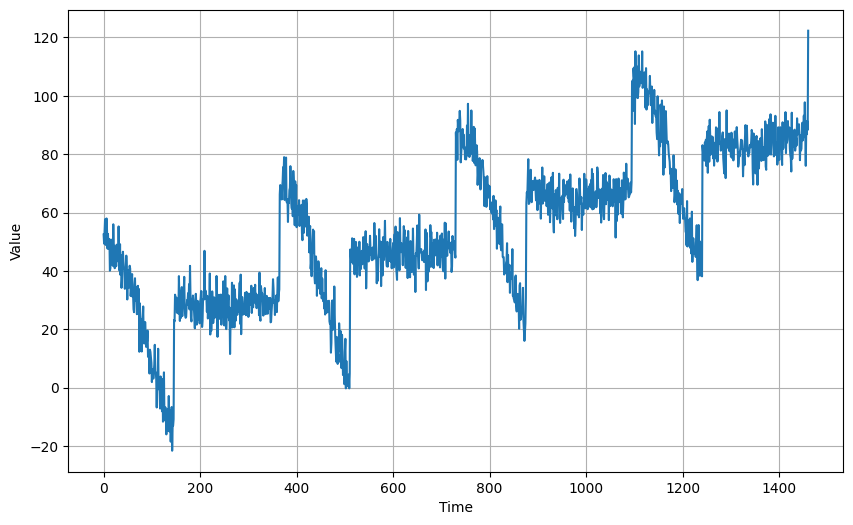

In [20]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [21]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Simple RNN Forecasting

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 44ms/step - loss: 289.4147 - mae: 289.9147 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 241.2868 - mae: 241.7868 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 21ms/step - loss: 168.6479 - mae: 169.1479 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 20ms/step - loss: 89.1224 - mae: 89.6224 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 22.6197 - mae: 23.1137 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 28.7414 - mae: 29.2392 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 15.1147 - mae: 15.6074 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 22ms/step - loss: 13.7675 - mae: 14.2584 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0s 25ms/step - loss: 12.5062 - mae: 13.0003 - l

(1e-07, 0.0001, 0.0, 30.0)

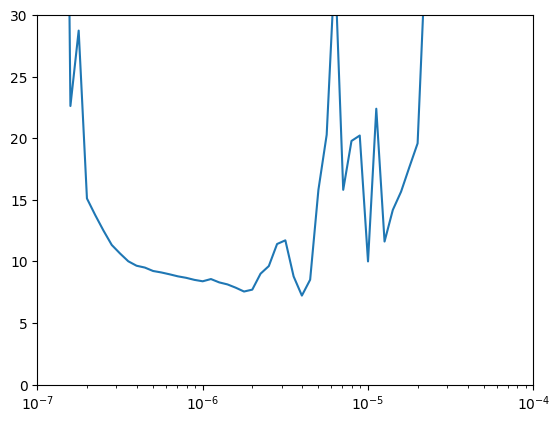

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
      6/Unknown - 2s 25ms/step - loss: 9558.9658 - mae: 9559.4648

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 5s 435ms/step - loss: 9476.7598 - mae: 9477.2588 - val_loss: 49439.7070 - val_mae: 49440.2070
Epoch 2/500
8/8 [==============================] - 0s 35ms/step - loss: 50275.8945 - mae: 50276.3906 - val_loss: 118383.8594 - val_mae: 118384.3594
Epoch 3/500
7/8 [=========================>....] - ETA: 0s - loss: 57408.4414 - mae: 57408.9414 

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 2s 342ms/step - loss: 54827.5156 - mae: 54828.0156 - val_loss: 12623.8721 - val_mae: 12624.3711
Epoch 4/500
8/8 [==============================] - 0s 35ms/step - loss: 42342.0234 - mae: 42342.5234 - val_loss: 28094.6738 - val_mae: 28095.1738
Epoch 5/500
7/8 [=========================>....] - ETA: 0s - loss: 60229.0039 - mae: 60229.5039

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 3s 404ms/step - loss: 59354.2188 - mae: 59354.7227 - val_loss: 1817.8521 - val_mae: 1818.3521
Epoch 6/500
8/8 [==============================] - 0s 35ms/step - loss: 16358.7002 - mae: 16359.2002 - val_loss: 39474.7109 - val_mae: 39475.2109
Epoch 7/500
8/8 [==============================] - 0s 37ms/step - loss: 22993.7207 - mae: 22994.2207 - val_loss: 20966.6387 - val_mae: 20967.1367
Epoch 8/500
8/8 [==============================] - 0s 34ms/step - loss: 20654.8125 - mae: 20655.3125 - val_loss: 13666.7285 - val_mae: 13667.2285
Epoch 9/500
8/8 [==============================] - 0s 50ms/step - loss: 19671.2207 - mae: 19671.7188 - val_loss: 26579.8438 - val_mae: 26580.3457
Epoch 10/500
8/8 [==============================] - 0s 39ms/step - loss: 21652.6211 - mae: 21653.1191 - val_loss: 25951.6094 - val_mae: 25952.1113
Epoch 11/500
8/8 [==============================] - 0s 39ms/step - loss: 19845.4512 - mae: 19845.9512 - val_loss: 39180.2617 - val_mae: 

INFO:tensorflow:Assets written to: my_checkpoint/assets


INFO:tensorflow:Assets written to: my_checkpoint/assets


8/8 [==============================] - 3s 367ms/step - loss: 23582.6445 - mae: 23583.1445 - val_loss: 1211.4824 - val_mae: 1211.9824
Epoch 22/500
8/8 [==============================] - 1s 58ms/step - loss: 24022.5234 - mae: 24023.0254 - val_loss: 66432.9688 - val_mae: 66433.4688
Epoch 23/500
8/8 [==============================] - 0s 35ms/step - loss: 23177.6074 - mae: 23178.1074 - val_loss: 50211.9805 - val_mae: 50212.4766
Epoch 24/500
8/8 [==============================] - 0s 36ms/step - loss: 40982.6211 - mae: 40983.1250 - val_loss: 9218.0615 - val_mae: 9218.5615
Epoch 25/500
8/8 [==============================] - 0s 35ms/step - loss: 24264.8105 - mae: 24265.3105 - val_loss: 77658.4297 - val_mae: 77658.9297
Epoch 26/500
8/8 [==============================] - 0s 39ms/step - loss: 68222.7031 - mae: 68223.2031 - val_loss: 54080.4727 - val_mae: 54080.9727
Epoch 27/500
8/8 [==============================] - 0s 39ms/step - loss: 26502.6328 - mae: 26503.1348 - val_loss: 9744.0059 - val_mae:

In [25]:
model = keras.models.load_model("my_checkpoint")

In [26]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


## Simple Mechanized RNN Forecasting

In [27]:
import sys
sys.path.append("..")

from mechanism.mechanized_sequential import MechanizedSequential
from mechanism.mechanized_sequential import Mechanism



In [30]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 2s 25ms/step - loss: 326.7534 - mae: 327.2542 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 284.1518 - mae: 284.6544 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 0s 27ms/step - loss: 213.2299 - mae: 213.7277 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 0s 37ms/step - loss: 117.3944 - mae: 117.8944 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 41.8034 - mae: 42.2986 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 45.3555 - mae: 45.8531 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 0s 29ms/step - loss: 31.3400 - mae: 31.8362 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 26.6126 - mae: 27.1094 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 0

(1e-07, 0.0001, 0.0, 30.0)

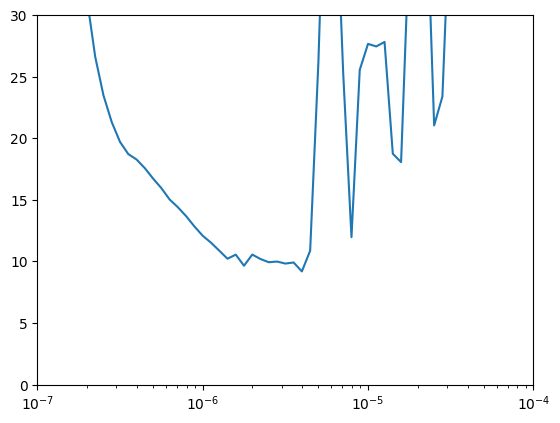

In [31]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = keras.callbacks.EarlyStopping(patience=50)
gaussian_model_checkpoint = keras.callbacks.ModelCheckpoint(
    "gaussian_model_checkpoint", save_best_only=True)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, gaussian_model_checkpoint])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      6/Unknown - 2s 25ms/step - loss: 12763.1963 - mae: 12763.6953In Gaussian Mechanism


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 4s 408ms/step - loss: 19872.4766 - mae: 19872.9727 - val_loss: 18634.7246 - val_mae: 18635.2246
Epoch 2/500
8/8 [==============================] - 0s 45ms/step - loss: 30692.5625 - mae: 30693.0625 - val_loss: 49468.9609 - val_mae: 49469.4648
Epoch 3/500
8/8 [==============================] - 0s 45ms/step - loss: 47613.6914 - mae: 47614.1875 - val_loss: 130746.8672 - val_mae: 130747.3594
Epoch 4/500
8/8 [==============================] - 1s 38ms/step - loss: 115767.9688 - mae: 115768.4609 - val_loss: 81811.5156 - val_mae: 81812.0312
Epoch 5/500
6/8 [=====================>........] - ETA: 0s - loss: 51868.4570 - mae: 51868.9492

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 390ms/step - loss: 52904.9375 - mae: 52905.4258 - val_loss: 10028.0264 - val_mae: 10028.5264
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 20302.7188 - mae: 20303.2207 - val_loss: 21077.3535 - val_mae: 21077.8535
Epoch 7/500
8/8 [==============================] - 0s 47ms/step - loss: 29795.8594 - mae: 29796.3652 - val_loss: 19540.4238 - val_mae: 19540.9180
Epoch 8/500
8/8 [==============================] - 0s 43ms/step - loss: 38343.0898 - mae: 38343.5859 - val_loss: 18449.6426 - val_mae: 18450.1387
Epoch 9/500
7/8 [=========================>....] - ETA: 0s - loss: 36389.2070 - mae: 36389.7070

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 366ms/step - loss: 35153.7266 - mae: 35154.2266 - val_loss: 6429.9976 - val_mae: 6430.4966
Epoch 10/500
8/8 [==============================] - 0s 34ms/step - loss: 19425.5547 - mae: 19426.0527 - val_loss: 30871.6406 - val_mae: 30872.1387
Epoch 11/500
8/8 [==============================] - 0s 42ms/step - loss: 34789.0430 - mae: 34789.5430 - val_loss: 75469.6172 - val_mae: 75470.1094
Epoch 12/500
8/8 [==============================] - 0s 37ms/step - loss: 25376.3672 - mae: 25376.8750 - val_loss: 20524.3262 - val_mae: 20524.8301
Epoch 13/500
8/8 [==============================] - 0s 38ms/step - loss: 37617.6562 - mae: 37618.1562 - val_loss: 24206.1816 - val_mae: 24206.6836
Epoch 14/500
8/8 [==============================] - ETA: 0s - loss: 36570.3672 - mae: 36570.8633

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 375ms/step - loss: 36570.3672 - mae: 36570.8633 - val_loss: 3547.7686 - val_mae: 3548.2681
Epoch 15/500
8/8 [==============================] - 0s 39ms/step - loss: 19237.9414 - mae: 19238.4434 - val_loss: 31755.6582 - val_mae: 31756.1641
Epoch 16/500
8/8 [==============================] - 0s 41ms/step - loss: 34776.1953 - mae: 34776.6953 - val_loss: 73642.1641 - val_mae: 73642.6641
Epoch 17/500
8/8 [==============================] - 0s 34ms/step - loss: 44054.3516 - mae: 44054.8438 - val_loss: 11325.5137 - val_mae: 11326.0137
Epoch 18/500
8/8 [==============================] - ETA: 0s - loss: 33947.3984 - mae: 33947.9023

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 407ms/step - loss: 33947.3984 - mae: 33947.9023 - val_loss: 2467.3784 - val_mae: 2467.8823
Epoch 19/500
8/8 [==============================] - 0s 40ms/step - loss: 35776.5352 - mae: 35777.0391 - val_loss: 72501.8047 - val_mae: 72502.3047
Epoch 20/500
8/8 [==============================] - 0s 50ms/step - loss: 42935.0508 - mae: 42935.5469 - val_loss: 21621.5176 - val_mae: 21622.0195
Epoch 21/500
8/8 [==============================] - 0s 34ms/step - loss: 36291.1094 - mae: 36291.6133 - val_loss: 17410.5449 - val_mae: 17411.0449
Epoch 22/500
8/8 [==============================] - 0s 50ms/step - loss: 36361.3633 - mae: 36361.8594 - val_loss: 61114.8398 - val_mae: 61115.3398
Epoch 23/500
8/8 [==============================] - 0s 36ms/step - loss: 41014.4727 - mae: 41014.9766 - val_loss: 28067.8965 - val_mae: 28068.3926
Epoch 24/500
8/8 [==============================] - 0s 34ms/step - loss: 37553.6992 - mae: 37554.2031 - val_loss: 20117.6270 - val_m

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 346ms/step - loss: 40672.2305 - mae: 40672.7344 - val_loss: 908.0090 - val_mae: 908.5124
Epoch 37/500
8/8 [==============================] - 0s 37ms/step - loss: 25266.8125 - mae: 25267.3164 - val_loss: 69438.1953 - val_mae: 69438.7031
Epoch 38/500
8/8 [==============================] - 0s 39ms/step - loss: 25174.0879 - mae: 25174.5957 - val_loss: 41817.9336 - val_mae: 41818.4375
Epoch 39/500
8/8 [==============================] - 0s 36ms/step - loss: 46242.0195 - mae: 46242.5234 - val_loss: 131927.5312 - val_mae: 131928.0312
Epoch 40/500
8/8 [==============================] - 0s 33ms/step - loss: 116439.3672 - mae: 116439.8750 - val_loss: 83681.7109 - val_mae: 83682.2031
Epoch 41/500
8/8 [==============================] - 0s 34ms/step - loss: 53002.2227 - mae: 53002.7148 - val_loss: 3997.6880 - val_mae: 3998.1880
Epoch 42/500
8/8 [==============================] - 0s 34ms/step - loss: 24449.4121 - mae: 24449.9141 - val_loss: 80993.3828 - val_m

INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


INFO:tensorflow:Assets written to: gaussian_model_checkpoint/assets


8/8 [==============================] - 3s 390ms/step - loss: 23807.4883 - mae: 23807.9863 - val_loss: 201.2444 - val_mae: 201.7444
Epoch 86/500
8/8 [==============================] - 0s 36ms/step - loss: 17582.0742 - mae: 17582.5684 - val_loss: 27347.1348 - val_mae: 27347.6387
Epoch 87/500
8/8 [==============================] - 1s 51ms/step - loss: 20369.4277 - mae: 20369.9277 - val_loss: 39409.6797 - val_mae: 39410.1758
Epoch 88/500
8/8 [==============================] - 0s 52ms/step - loss: 23036.8477 - mae: 23037.3496 - val_loss: 20348.3652 - val_mae: 20348.8594
Epoch 89/500
8/8 [==============================] - 0s 39ms/step - loss: 22476.0430 - mae: 22476.5469 - val_loss: 4097.5469 - val_mae: 4098.0454
Epoch 90/500
8/8 [==============================] - 0s 43ms/step - loss: 18642.1387 - mae: 18642.6387 - val_loss: 18038.6016 - val_mae: 18039.1074
Epoch 91/500
8/8 [==============================] - 0s 36ms/step - loss: 18857.6953 - mae: 18858.1953 - val_loss: 41473.1953 - val_mae: 

In [33]:
gaussian_model = keras.models.load_model("gaussian_model_checkpoint",
                                         custom_objects={'MechanizedSequential':MechanizedSequential})

In [34]:
gaussian_rnn_forecast = model_forecast(
    gaussian_model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


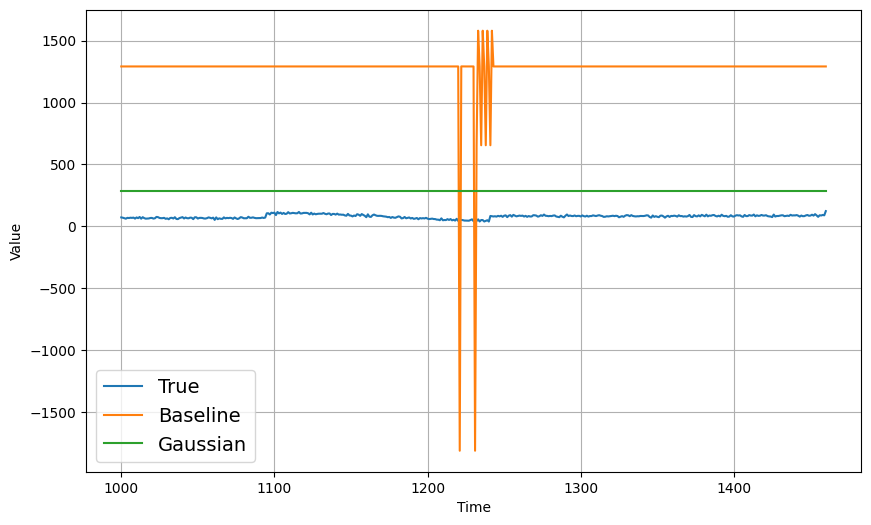

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [36]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1212.8242

In [37]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

202.56004

## Sequence-to-Sequence Forecasting

In [38]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [39]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]


In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 29ms/step - loss: 56.3125 - mae: 56.8122 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 25.6853 - mae: 26.1793 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 25.8385 - mae: 26.3360 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 19.1514 - mae: 19.6419 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 23ms/step - loss: 18.2910 - mae: 18.7808 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 17.4896 - mae: 17.9785 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 16.7607 - mae: 17.2477 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 23ms/step - loss: 16.1741 - mae: 16.6600 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 27ms/step - loss: 15.6358 - mae: 16.1202 - lr: 1.8

(1e-07, 0.0001, 0.0, 30.0)

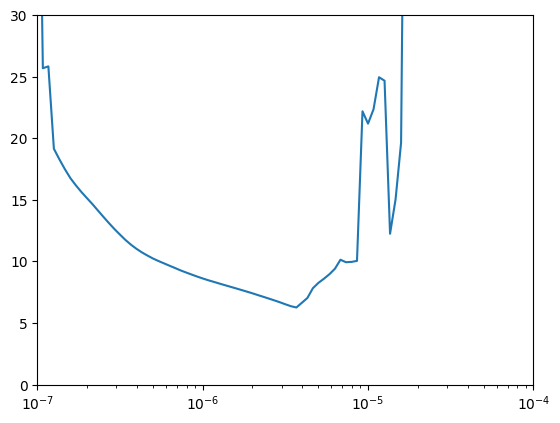

In [41]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [42]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 2s 77ms/step - loss: 16690.4980 - mae: 16691.0000 - val_loss: 28360.2422 - val_mae: 28360.7422
Epoch 2/500
8/8 [==============================] - 0s 35ms/step - loss: 20836.5684 - mae: 20837.0703 - val_loss: 33781.7344 - val_mae: 33782.2383
Epoch 3/500
8/8 [==============================] - 0s 36ms/step - loss: 21873.9941 - mae: 21874.4961 - val_loss: 32487.6426 - val_mae: 32488.1426
Epoch 4/500
8/8 [==============================] - 0s 36ms/step - loss: 21696.1836 - mae: 21696.6816 - val_loss: 31866.1074 - val_mae: 31866.6055
Epoch 5/500
8/8 [==============================] - 0s 43ms/step - loss: 22669.4492 - mae: 22669.9531 - val_loss: 27892.6816 - val_mae: 27893.1797
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 21387.5723 - mae: 21388.0723 - val_loss: 36847.5547 - val_mae: 36848.0508
Epoch 7/500
8/8 [==============================] - 0s 37ms/step - loss: 21592.5410 - mae: 21593.0410 - val_loss: 40365.1211 

In [43]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 4ms/step


## Mechanized Sequence-to-Sequence Forecast 

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

gaussian_history = gaussian_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
In Gaussian Mechanism
In Gaussian Mechanism
8/8 [==============================] - 2s 25ms/step - loss: 32.3289 - mae: 32.8273 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 19.4581 - mae: 19.9526 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 16.9986 - mae: 17.4900 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 15.7009 - mae: 16.1912 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 14.3816 - mae: 14.8702 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 13.5683 - mae: 14.0537 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 13.1228 - mae: 13.6091 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 28ms/step - loss: 12.8443 - mae: 13.3294 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 28ms/s

(1e-07, 0.0001, 0.0, 30.0)

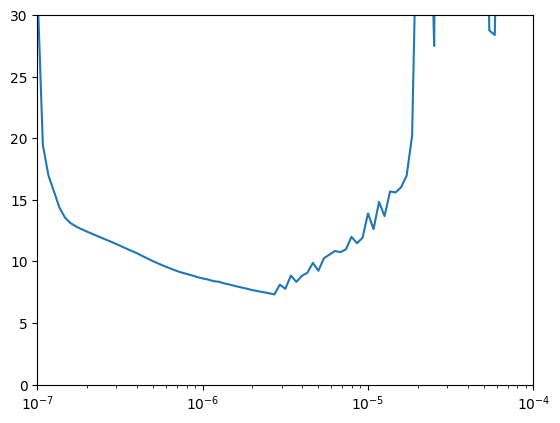

In [45]:
plt.semilogx(gaussian_history.history["lr"], gaussian_history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [46]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

gaussian_model = MechanizedSequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
gaussian_model.choose_mech(Mechanism.GAUSSIAN)
gaussian_model.set_gaussian_para(0, 0.05)

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
gaussian_model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
gaussian_model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
In Gaussian Mechanism
In Gaussian Mechanism
      6/Unknown - 2s 25ms/step - loss: 7701.5923 - mae: 7702.0918In Gaussian Mechanism
8/8 [==============================] - 3s 80ms/step - loss: 16087.0723 - mae: 16087.5703 - val_loss: 5110.4424 - val_mae: 5110.9424
Epoch 2/500
8/8 [==============================] - 0s 38ms/step - loss: 67422.3828 - mae: 67422.8750 - val_loss: 81585.3047 - val_mae: 81585.8047
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 94306.6953 - mae: 94307.1797 - val_loss: 86852.7266 - val_mae: 86853.2188
Epoch 4/500
8/8 [==============================] - 0s 38ms/step - loss: 48098.2305 - mae: 48098.7305 - val_loss: 14519.1260 - val_mae: 14519.6289
Epoch 5/500
8/8 [==============================] - 0s 39ms/step - loss: 34840.3164 - mae: 34840.8125 - val_loss: 60831.7461 - val_mae: 60832.2539
Epoch 6/500
8/8 [==============================] - 0s 38ms/step - loss: 38766.6094 - mae: 38767.1133 - val_loss: 42989.9805 - val_mae: 42990.

In [47]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

gaussian_rnn_forecast = model_forecast(gaussian_model, series[..., np.newaxis], window_size)
gaussian_rnn_forecast = gaussian_rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 0s 5ms/step


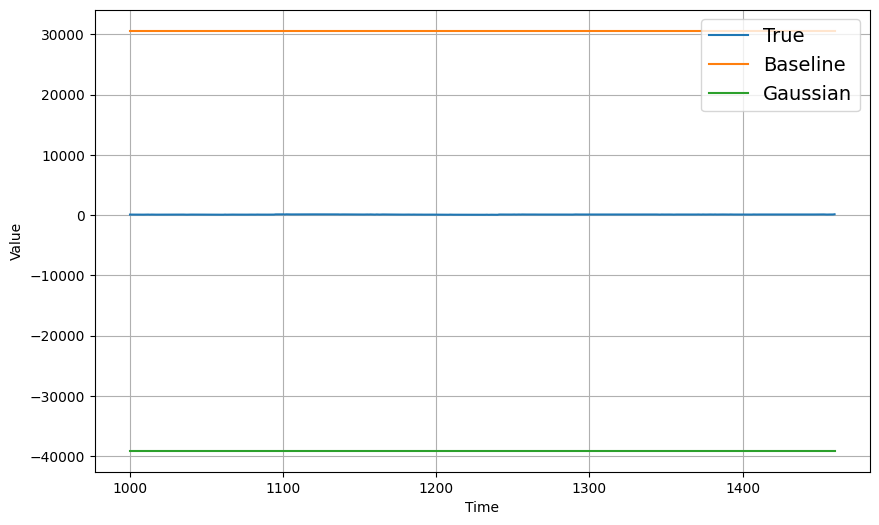

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "True")
plot_series(time_valid, rnn_forecast, label = "Baseline")
plot_series(time_valid, gaussian_rnn_forecast, label = "Gaussian")

In [49]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

30510.22

In [50]:
keras.metrics.mean_absolute_error(x_valid, gaussian_rnn_forecast).numpy()

39203.613